# Setup

In [2]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [3]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [4]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [5]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [6]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [7]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [8]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [9]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

In [10]:
calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, 1288)

CaLNG price: $7.50
---
Peak intake from pipeline: 181 MMcf
Total peak months intake from pipeline: 12,428 MMcf
Total intake from CaLNG: 1,288 MMcf
---
Total amount paid to pipeline: $18,463,575
Total amount paid to CaLNG: $9,660,000
Total cost for utility: $28,123,575
Savings from using CaLNG: $12,080,986
---
Total cost if average draw daily: $15,342,871


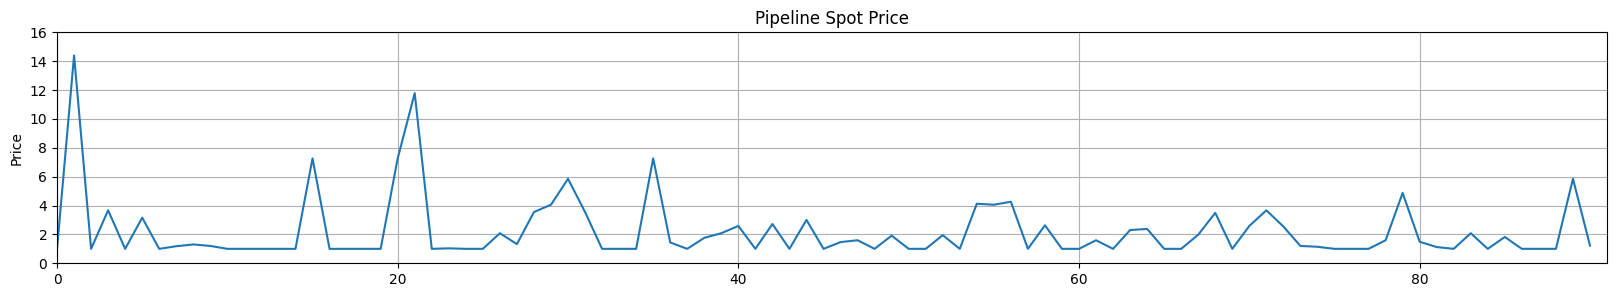

In [11]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_price')
plt.title('Pipeline Spot Price')
plt.axis([0, 91, 0, 16])
plt.grid()
plt.xlabel("")
plt.ylabel("Price")
plt.show()

# Demand

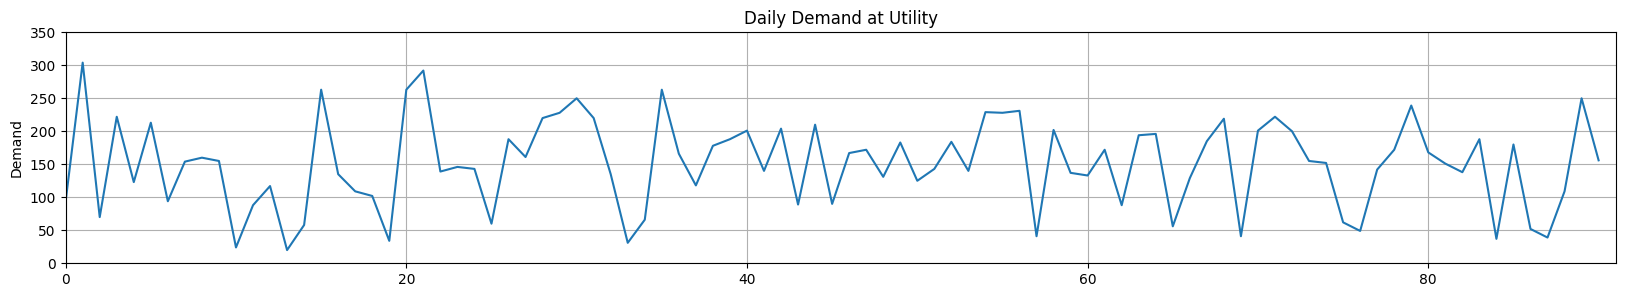

In [12]:
sns.lineplot(data=usage_data, x='price_index', y='Demand')
plt.title('Daily Demand at Utility')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# Intake from Pipeline

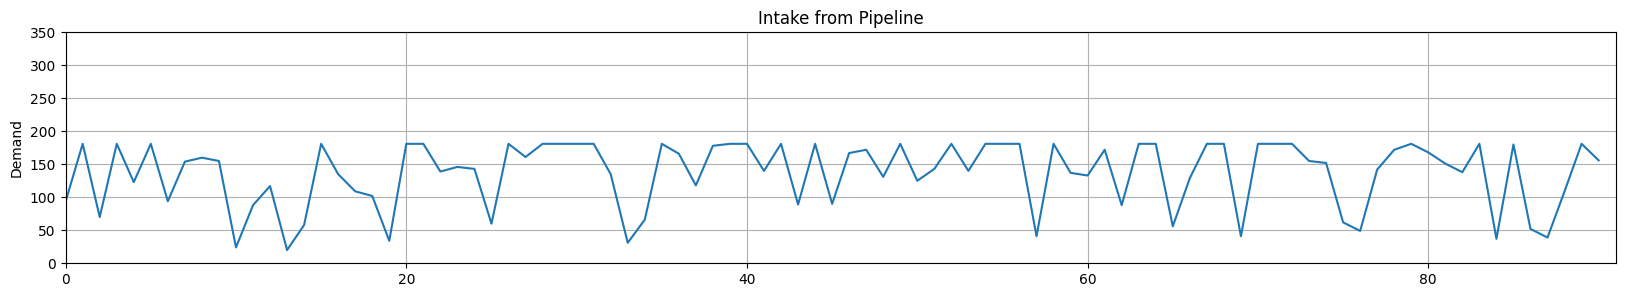

In [13]:
sns.lineplot(data=usage_data, x='price_index', y='pipeline_intake')
plt.title('Intake from Pipeline')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Demand")
plt.show()

# CaLNG Purchase

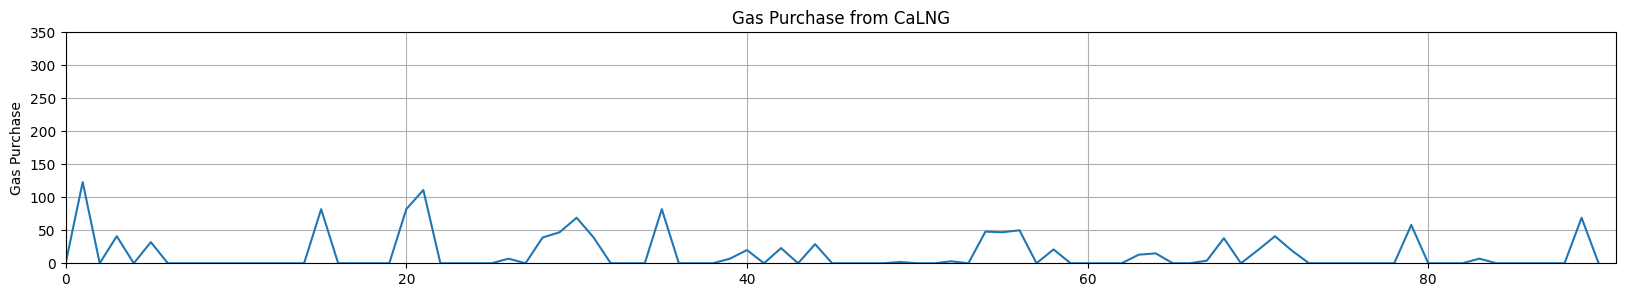

In [14]:
sns.lineplot(data=usage_data, x='price_index', y='purchase_from_calng')
plt.title('Gas Purchase from CaLNG')
plt.axis([0, 91, 0, 350])
plt.grid()
plt.xlabel("")
plt.ylabel("Gas Purchase")
plt.show()

# Intake vs. Spot Price

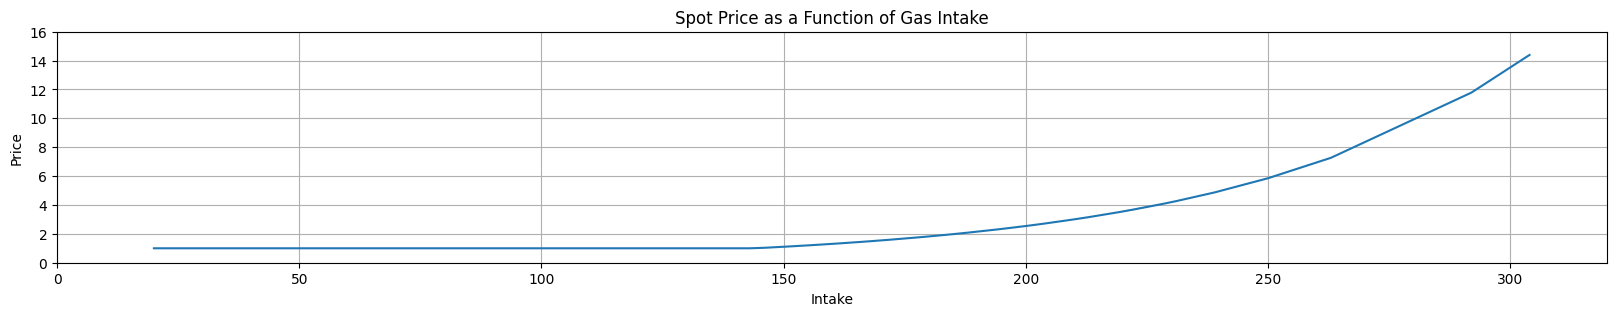

In [15]:
sns.lineplot(data=intake_price_data, x='Intake', y='Price')
plt.title('Spot Price as a Function of Gas Intake')
plt.axis([0, 320, 0, 16])
plt.grid()
plt.show()

# Option

In [16]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

In [17]:
# simulate demand data
sim_demand_data = demand_data.copy()

# generate sample
demand_sample = np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data))
demand_sample = np.round(np.where(demand_sample < 0, 0, demand_sample),0)

sim_demand_data['Demand'] = demand_sample
sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake_from_pipeline, total_lng)

calculate_cost_statistics(sim_usage_data, calng_price, peak_intake_from_pipeline, total_lng)

CaLNG price: $7.50
---
Peak intake from pipeline: 180 MMcf
Total peak months intake from pipeline: 12,028 MMcf
Total intake from CaLNG: 858 MMcf
---
Total amount paid to pipeline: $16,599,498
Total amount paid to CaLNG: $9,000,000
Total cost for utility: $25,599,498
Savings from using CaLNG: $3,878,258
---
Total cost if average draw daily: $12,886,000


# Option Optimization
In progress

In [18]:
# number of simulation draws per scenario
num_draws = 5000

# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

cost_stat_list = []

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = []
        for n in range(num_draws):
            # simulate demand data
            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample

            # get simulated usage data
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)


            sims.append(cost_stat_dict)


        cost_stat_list.append(np.mean(pd.DataFrame(sims), axis=0))

df = pd.DataFrame(cost_stat_list)



In [20]:
df.to_csv('simulation.csv')

In [28]:
df

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
0,170.0,700.0,12423.1324,698.3974,2.183646e+07,5250000.0,2.708646e+07,4.569560e+06,1.375863e+07
1,175.0,700.0,12417.5346,693.8424,2.104190e+07,5250000.0,2.629190e+07,5.278993e+06,1.372307e+07
2,180.0,700.0,12429.0086,681.5990,2.041041e+07,5250000.0,2.566041e+07,5.999445e+06,1.372058e+07
3,185.0,700.0,12461.9264,656.3444,2.007751e+07,5250000.0,2.532751e+07,6.603183e+06,1.373920e+07
4,190.0,700.0,12524.1482,611.8404,2.007741e+07,5250000.0,2.532741e+07,6.965004e+06,1.377981e+07
...,...,...,...,...,...,...,...,...,...
67,175.0,1250.0,12102.5268,992.5254,1.651133e+07,9375000.0,2.588633e+07,7.408537e+06,1.369583e+07
68,180.0,1250.0,12224.0046,879.8800,1.718957e+07,9375000.0,2.656457e+07,7.599619e+06,1.370302e+07
69,185.0,1250.0,12356.1558,775.1792,1.806154e+07,9375000.0,2.743654e+07,7.756688e+06,1.377246e+07
70,190.0,1250.0,12452.5232,671.6910,1.894123e+07,9375000.0,2.831623e+07,7.574111e+06,1.376122e+07


In [23]:
optimal_row = df.loc[df['total_utility_cost'].idxmin()]
optimal_total_lng = optimal_row['total_lng_purchase']
optimal_peak_intake = optimal_row['peak_intake_from_pipeline']

print(f"Optimal total LNG: {optimal_total_lng}, Optimal peak intake from pipeline: {optimal_peak_intake}")

Optimal total LNG: 850.0, Optimal peak intake from pipeline: 180.0


In [26]:
filtered_df

,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
2,180.0,700.0,12429.0086,681.5990,2.041041e+07,5250000.0,2.566041e+07,5.999445e+06,1.372058e+07
8,180.0,750.0,12397.4220,721.2040,1.985888e+07,5625000.0,2.548388e+07,6.305636e+06,1.374061e+07
14,180.0,800.0,12377.2222,756.7074,1.943241e+07,6000000.0,2.543241e+07,6.674477e+06,1.376890e+07
20,180.0,850.0,12323.0162,783.8156,1.873143e+07,6375000.0,2.510643e+07,6.834896e+06,1.370873e+07
26,180.0,900.0,12312.7574,811.0576,1.846626e+07,6750000.0,2.521626e+07,7.033169e+06,1.375698e+07
32,180.0,950.0,12278.8172,828.4354,1.806649e+07,7125000.0,2.519149e+07,7.135643e+06,1.371182e+07
38,180.0,1000.0,12266.1202,851.1782,1.779770e+07,7500000.0,2.529770e+07,7.346460e+06,1.373175e+07
44,180.0,1050.0,12249.1024,858.2562,1.756489e+07,7875000.0,2.543989e+07,7.364841e+06,1.371318e+07
50,180.0,1100.0,12243.9118,867.9152,1.745477e+07,8250000.0,2.570477e+07,7.527713e+06,1.373377e+07
56,180.0,1150.0,12241.5334,874.2030,1.731684e+07,8625000.0,2.594184e+07,7.511055e+06,1.373133e+07


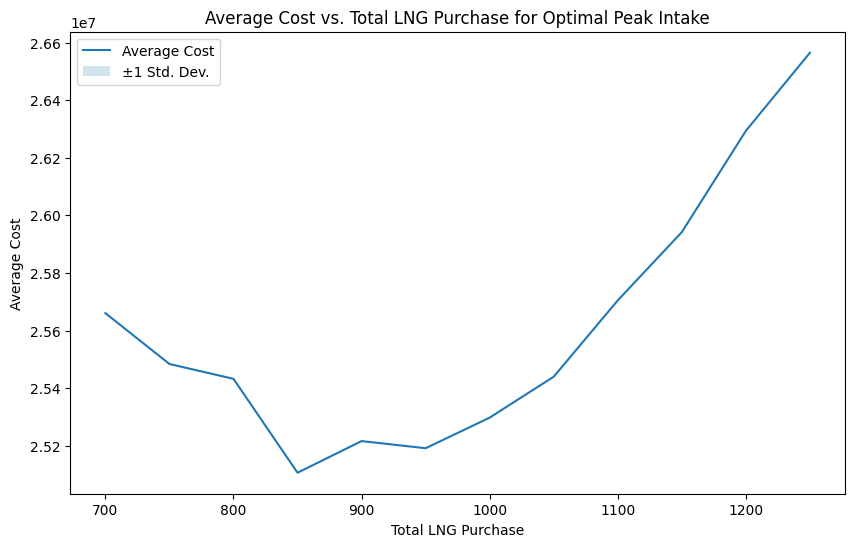

In [24]:
optimal_peak = optimal_peak_intake  # Use the optimal peak intake from pipeline value you've found

# Filter df for rows where peak_intake_from_pipeline is optimal
filtered_df = df[df['peak_intake_from_pipeline'] == optimal_peak]

# Calculate mean and std dev of cost for each total_lng_purchase value
avg_cost = filtered_df.groupby('total_lng_purchase')['total_utility_cost'].mean()
std_dev = filtered_df.groupby('total_lng_purchase')['total_utility_cost'].std()

plt.figure(figsize=(10, 6))
plt.plot(avg_cost.index, avg_cost, label='Average Cost')
plt.fill_between(avg_cost.index, avg_cost - std_dev, avg_cost + std_dev, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Total LNG Purchase')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Total LNG Purchase for Optimal Peak Intake')
plt.legend()
plt.show()

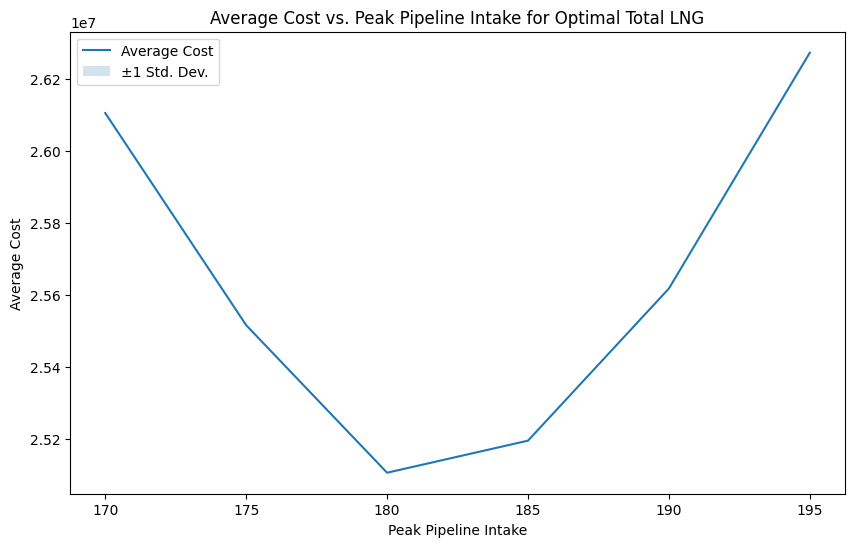

In [27]:
optimal_lng = optimal_total_lng  # Use the optimal total LNG purchase value you've found

# Filter df for rows where total_lng_purchase is optimal
filtered_df = df[df['total_lng_purchase'] == optimal_lng]

# Calculate mean and std dev of cost for each peak_intake_from_pipeline value
avg_cost = filtered_df.groupby('peak_intake_from_pipeline')['total_utility_cost'].mean()
std_dev = filtered_df.groupby('peak_intake_from_pipeline')['total_utility_cost'].std()

plt.figure(figsize=(10, 6))
plt.plot(avg_cost.index, avg_cost, label='Average Cost')
plt.fill_between(avg_cost.index, avg_cost - std_dev, avg_cost + std_dev, alpha=0.2, label='±1 Std. Dev.')
plt.xlabel('Peak Pipeline Intake')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Peak Pipeline Intake for Optimal Total LNG')
plt.legend()
plt.show()

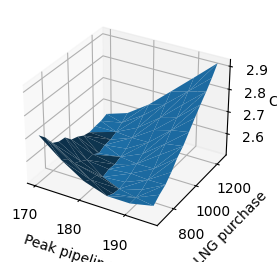

In [29]:
from mpl_toolkits.mplot3d import Axes3D


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.plot_trisurf(df["peak_intake_from_pipeline"], df["total_lng_purchase"], df["total_utility_cost"])

ax.set_xlabel('Peak pipeline')
ax.set_ylabel('LNG purchase')
ax.set_zlabel('Cost')

plt.show()
